In [531]:
drive_path = '/Volumes/Brain2016'
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_rel
from scipy.stats import variation
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy import signal
from scipy.stats import expon
import matplotlib.pyplot as plt

%matplotlib inline
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.drifting_gratings import DriftingGratings
import seaborn
import h5py
# import glob
# import time as tm

manifest_path = os.path.join(drive_path,'BrainObservatory','manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_path)
expMetaData = pd.DataFrame(boc.get_ophys_experiments())
cells = pd.DataFrame.from_records(boc.get_cell_specimens())

# Analyze all DG (three_session_A), subdivided by targeted_structure and cre_line

In [54]:
walkRun_DG_DF = pd.DataFrame(columns = ['stat_all','run_all','stat_VISp','run_VISp','stat_VISpm','run_VISpm',
                                     'stat_VISl','run_VISl','stat_VISal','run_VISal',
                                     'stat_Cux2','run_Cux2','stat_Rorb','run_Rorb','stat_Rbp4','run_Rbp4',
                                     'stat_Scnn1a','run_Scnn1a'],
                         index = ['trial_means'])

osi_dgMax = 1.5
osi_dgMin = 0
walkThresh = 1
runThresh = 5

for expType in range(9):
    walkMeans = []
    runMeans = []
    if expType == 0:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A')]
        print("three_session_A")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 1:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.targeted_structure == 'VISp')]
        print("three_session_A and VISp")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 2:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.targeted_structure == 'VISpm')]
        print("three_session_A and VISpm")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 3:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.targeted_structure == 'VISl')]
        print("three_session_A and VISl")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 4:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.targeted_structure == 'VISal')]
        print("three_session_A and VISal")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 5:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.cre_line == 'Cux2-CreERT2')]
        print("three_session_A and Cux2")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 6:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.cre_line == 'Rorb-IRES2-Cre')]
        print("three_session_A and Rorb")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 7:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.cre_line == 'Rbp4-Cre')]
        print("three_session_A and Rbp4")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 8:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.cre_line == 'Scnn1a-Tg3-Cre')]
        print("three_session_A and Scnn1a")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])

    for expInd in currSess_metaData.index:
        expContainerID = currSess_metaData.experiment_container_id[expInd]
        expID = currSess_metaData.id[expInd]
        exp = boc.get_ophys_experiment_data(ophys_experiment_id = expID)
        _, dF = exp.get_dff_traces()
        path = r'/Volumes/Brain2016/BrainObservatory/ophys_analysis/%d_%s_analysis.h5' % (expID, currSess_metaData.session_type[expInd])
        sResp = pd.read_hdf(path, 'analysis/sweep_response_dg')
        sResp_mean = pd.read_hdf(path, 'analysis/mean_sweep_response_dg')
        sTabl = pd.read_hdf(path, 'analysis/stim_table_dg')
        cellIDs = exp.get_cell_specimen_ids()

        relevCells = cells[cells.experiment_container_id == int(expContainerID)]
        relevCells = relevCells[~np.isnan(relevCells.osi_dg) & \
                                   np.less_equal(relevCells.osi_dg,osi_dgMax) & \
                                   np.greater_equal(relevCells.osi_dg,osi_dgMin)] # relevant cells are those with osi_dg and within bounds

        for currCell in relevCells.index:
            cellInd = np.where(relevCells.cell_specimen_id[currCell] == cellIDs)[0][0]
            prefDir = relevCells.pref_dir_dg[currCell]
            prefTF = relevCells.pref_tf_dg[currCell]

            allRun = []
            prefTF_mask = sTabl.temporal_frequency == prefTF
            prefDir_mask = sTabl.orientation == prefDir
            for currSweep in sTabl[prefTF_mask & prefDir_mask].index:
                allRun.append(sResp_mean['dx'][currSweep])
            runMask = np.greater_equal(allRun,runThresh)
            stillMask = np.less(allRun,walkThresh)
            
            if (sum(runMask) >= 5) and (sum(stillMask) >= 5): # if <5 trials running or stationary
                walkVals = sResp_mean[str(cellInd)][prefTF_mask & prefDir_mask][stillMask]
                runVals = sResp_mean[str(cellInd)][prefTF_mask & prefDir_mask][runMask]
                
                meanFlag = False
                for tmp in walkVals:
                    if np.greater_equal(tmp,50):
                        meanFlag = True
                for tmp in runVals:
                    if np.greater_equal(tmp,50):
                        meanFlag = True

                if meanFlag == True:
                    walkMeans.append(walkVals.mean())
                    runMeans.append(runVals.mean())
    if expType == 0:
        walkRun_DG_DF.stat_all.trial_means = walkMeans
        walkRun_DG_DF.run_all.trial_means = runMeans
    elif expType == 1:
        walkRun_DG_DF.stat_VISp.trial_means = walkMeans
        walkRun_DG_DF.run_VISp.trial_means = runMeans
    elif expType == 2:
        walkRun_DG_DF.stat_VISpm.trial_means = walkMeans
        walkRun_DG_DF.run_VISpm.trial_means = runMeans
    elif expType == 3:
        walkRun_DG_DF.stat_VISl.trial_means = walkMeans
        walkRun_DG_DF.run_VISl.trial_means = runMeans
    elif expType == 4:
        walkRun_DG_DF.stat_VISal.trial_means = walkMeans
        walkRun_DG_DF.run_VISal.trial_means = runMeans
    elif expType == 5:
        walkRun_DG_DF.stat_Cux2.trial_means = walkMeans
        walkRun_DG_DF.run_Cux2.trial_means = runMeans
    elif expType == 6:
        walkRun_DG_DF.stat_Rorb.trial_means = walkMeans
        walkRun_DG_DF.run_Rorb.trial_means = runMeans
    elif expType == 7:
        walkRun_DG_DF.stat_Rbp4.trial_means = walkMeans
        walkRun_DG_DF.run_Rbp4.trial_means = runMeans
    elif expType == 8:
        walkRun_DG_DF.stat_Scnn1a.trial_means = walkMeans
        walkRun_DG_DF.run_Scnn1a.trial_means = runMeans
print("Done")

three_session_A
	79 sessions to sort through
three_session_A and VISp
	25 sessions to sort through
three_session_A and VISpm
	21 sessions to sort through
three_session_A and VISl
	16 sessions to sort through
three_session_A and VISal
	17 sessions to sort through
three_session_A and Cux2
	42 sessions to sort through
three_session_A and Rorb
	17 sessions to sort through
three_session_A and Rbp4
	16 sessions to sort through
three_session_A and Scnn1a
	4 sessions to sort through
Done


In [12]:
walkRun_DG_DF.head()

,stat_all,run_all,stat_VISp,run_VISp,stat_VISpm,run_VISpm,stat_VISl,run_VISl,stat_VISal,run_VISal,stat_Cux2,run_Cux2,stat_Rorb,run_Rorb,stat_Rbp4,run_Rbp4,stat_Scnn1a,run_Scnn1a
trial_means,"[15.6986445636, 0.541182316095, 2.304666996, 0...","[2.13974773884, 16.966840148, 19.1783124924, 1...","[15.6986445636, 0.541182316095, 2.304666996, 0...","[2.13974773884, 16.966840148, 19.1783124924, 1...","[22.7771039903, 25.8687523305, 52.0697451168, ...","[0.277761723314, 26.876226902, 4.34744631251, ...","[1.37016425328, 2.36911569701, 121.202106357, ...","[17.3857116699, 24.8697773616, 87.8350028992, ...","[0.00188424997032, 7.19560775492, -1.836883474...","[47.3026708762, 0.469205249101, 15.3048122397,...","[1.37016425328, 2.36911569701, 121.202106357, ...","[17.3857116699, 24.8697773616, 87.8350028992, ...","[15.6986445636, 0.541182316095, 2.304666996, 0...","[2.13974773884, 16.966840148, 19.1783124924, 1...","[14.8179041545, 2.08200335503, 10.9565176964, ...","[78.2076708476, 124.614014217, 1.88536442071, ...","[8.54624689288, 10.5370936493, -0.569350338644...","[25.0860919952, 84.912443161, 32.0961171627, 4..."


### Boxplots Sorted by Region

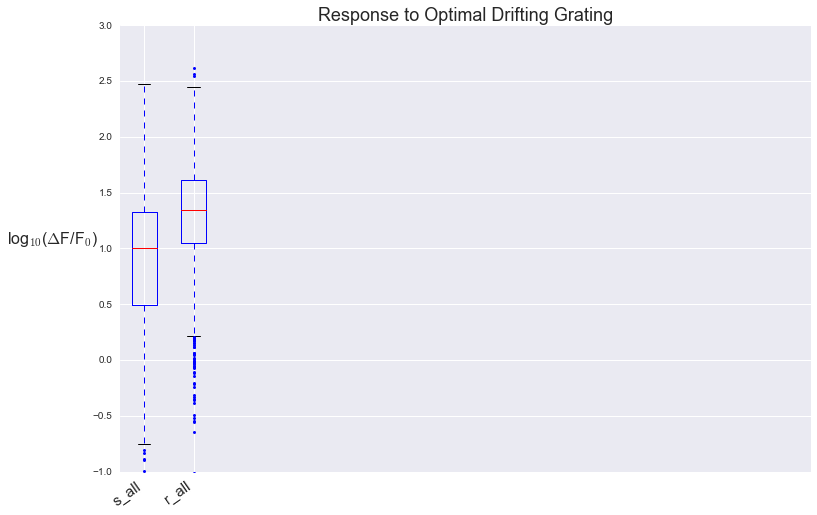

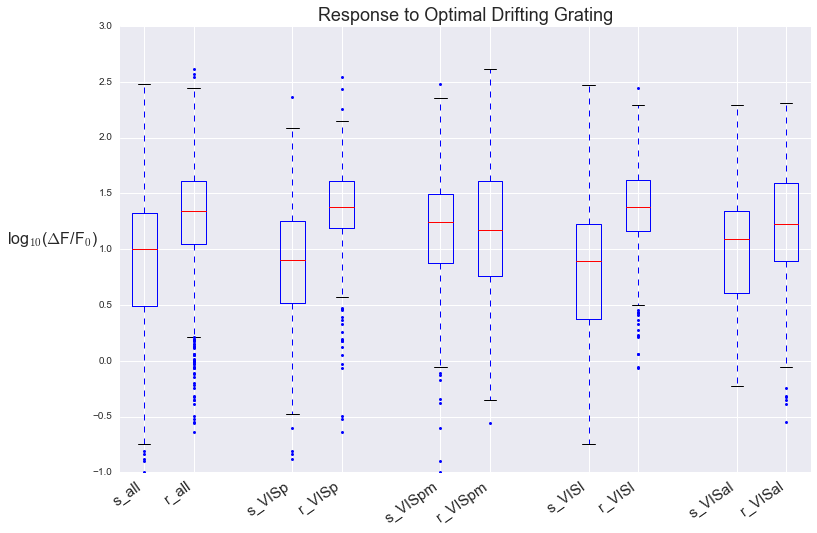

In [547]:
# fig, ax = plt.subplots(figsize=(12,8))
# ax.boxplot([walkRun_DG_DF.stat_all.trial_means,
#             walkRun_DG_DF.run_all.trial_means,
#             walkRun_DG_DF.stat_VISp.trial_means,
#             walkRun_DG_DF.run_VISp.trial_means,
#             walkRun_DG_DF.stat_VISpm.trial_means,
#             walkRun_DG_DF.run_VISpm.trial_means,
#             walkRun_DG_DF.stat_VISl.trial_means,
#             walkRun_DG_DF.run_VISl.trial_means,
#             walkRun_DG_DF.stat_VISal.trial_means,
#             walkRun_DG_DF.run_VISal.trial_means],
#           positions = [0,1,3,4,6,7,9,10,12,13])
# ax.set_ylim(-20,90)
# ax.set_ylabel('$\Delta$F/F$_0$',fontsize=16, rotation=0)
# ax.set_xticks([0,1,3,4,6,7,9,10,12,13])
# ax.set_xticklabels(['s_all','r_all','s_VISp','r_VISp','s_VISpm','r_VISpm','s_VISl','r_VISl','s_VISal','r_VISal'], 
#                    rotation=35, ha='right', fontsize = 13)
# ax.yaxis.labelpad = 40
# ax.set_title('Response to Optimal Drifting Grating', fontsize=18)


# fig, ax = plt.subplots(figsize=(12,8))
# ax.boxplot([np.log10(walkRun_DG_DF.stat_all.trial_means),
#             np.log10(walkRun_DG_DF.run_all.trial_means),
#             np.log10(walkRun_DG_DF.stat_VISp.trial_means),
#             np.log10(walkRun_DG_DF.run_VISp.trial_means),
#             np.log10(walkRun_DG_DF.stat_VISpm.trial_means),
#             np.log10(walkRun_DG_DF.run_VISpm.trial_means),
#             np.log10(walkRun_DG_DF.stat_VISl.trial_means),
#             np.log10(walkRun_DG_DF.run_VISl.trial_means),
#             np.log10(walkRun_DG_DF.stat_VISal.trial_means),
#             np.log10(walkRun_DG_DF.run_VISal.trial_means)],
#        labels=['s_all','r_all','s_VISp','r_VISp','s_VISpm','r_VISpm','s_VISl','r_VISl','s_VISal','r_VISal'],
#           positions=[0,1,3,4,6,7,9,10,12,13])
# # ax.set_ylim(-20,90)
# ax.set_ylabel('Response to Optimal Drifting Grating')


a = np.log10(walkRun_DG_DF.stat_all.trial_means)
b = np.log10(walkRun_DG_DF.run_all.trial_means)
c = np.log10(walkRun_DG_DF.stat_VISp.trial_means)
d = np.log10(walkRun_DG_DF.run_VISp.trial_means)
e = np.log10(walkRun_DG_DF.stat_VISpm.trial_means)
f = np.log10(walkRun_DG_DF.run_VISpm.trial_means)
g = np.log10(walkRun_DG_DF.stat_VISl.trial_means)
h = np.log10(walkRun_DG_DF.run_VISl.trial_means)
i = np.log10(walkRun_DG_DF.stat_VISal.trial_means)
j = np.log10(walkRun_DG_DF.run_VISal.trial_means)
tmp = [a,b,c,d,e,f,g,h,i,j]
fig,ax = plt.subplots(figsize=(12,8))
ax.boxplot([a[~np.isnan(a)],b[~np.isnan(b)]],sym='k.',positions=[0,1],widths=0.5)
ax.set_ylim(-1,3)
ax.set_xlim(-0.5,13.5)
ax.set_ylabel('log$_{10}$($\Delta$F/F$_0$)',fontsize=16, rotation=0)
ax.set_xticks([0,1])
ax.set_xticklabels(['s_all','r_all'], 
                   rotation=35, ha='right', fontsize = 15)
ax.yaxis.labelpad = 40
ax.set_title('Response to Optimal Drifting Grating', fontsize=18)
fig.subplots_adjust(left=0.15,right=0.95)
# fig.tight_layout()
plt.savefig('/Users/bilalbari/Dropbox/SWDB_BLAZEN_NEURONZZ/finalPresentation/runModulation_DG_regions_partial.png')

fig,ax = plt.subplots(figsize=(12,8))
ax.boxplot([i[~np.isnan(i)] for i in tmp],positions=[0,1,3,4,6,7,9,10,12,13],sym='k.',widths=0.5);
ax.set_ylim(-1,3)
ax.set_xlim(-0.5,13.5)
ax.set_ylabel('log$_{10}$($\Delta$F/F$_0$)',fontsize=16, rotation=0)
ax.set_xticks([0,1,3,4,6,7,9,10,12,13])
ax.set_xticklabels(['s_all','r_all','s_VISp','r_VISp','s_VISpm','r_VISpm','s_VISl','r_VISl','s_VISal','r_VISal'], 
                   rotation=35, ha='right', fontsize = 15)
ax.yaxis.labelpad = 40
ax.set_title('Response to Optimal Drifting Grating', fontsize=18)
fig.subplots_adjust(left=0.15,right=0.95)
plt.savefig('/Users/bilalbari/Dropbox/SWDB_BLAZEN_NEURONZZ/finalPresentation/runModulation_DG_regions.png')

In [360]:
# a = np.asarray(walkRun_DG_DF.stat_all.trial_means)
# b = np.asarray(walkRun_DG_DF.run_all.trial_means)
# c = np.asarray(walkRun_DG_DF.stat_VISp.trial_means)
# d = np.asarray(walkRun_DG_DF.run_VISp.trial_means)
# e = np.asarray(walkRun_DG_DF.stat_VISpm.trial_means)
# f = np.asarray(walkRun_DG_DF.run_VISpm.trial_means)
# g = np.asarray(walkRun_DG_DF.stat_VISl.trial_means)
# h = np.asarray(walkRun_DG_DF.run_VISl.trial_means)
# i = np.asarray(walkRun_DG_DF.stat_VISal.trial_means)
# j = np.asarray(walkRun_DG_DF.run_VISal.trial_means)

# fig, ax = plt.subplots(figsize=(12,8))
# ax.boxplot([a[a>0],b[b>0],c[c>0],d[d>0],e[e>0],f[f>0],g[g>0],h[h>0],i[i>0],j[j>0]],
#        labels=['s_all','r_all','s_VISp','r_VISp','s_VISpm','r_VISpm','s_VISl','r_VISl','s_VISal','r_VISal'],
#           positions=[0,1,3,4,6,7,9,10,12,13])
# ax.set_ylim(-20,90)
# ax.set_ylabel('Response to Optimal Drifting Grating')


# print('stat_all: ',kurtosis(a))
# print('run_all: ',kurtosis(b))
# print('stat_VISp: ',kurtosis(c))
# print('run_VISp: ',kurtosis(d))
# print('stat_VISpm: ',kurtosis(e))
# print('run_VISpm: ',kurtosis(f))
# print('stat_VISl: ',kurtosis(g))
# print('run_VISl: ',kurtosis(h))
# print('stat_VISal: ',kurtosis(i))
# print('run_VISal: ',kurtosis(j))


### Boxplots Sorted by Cre Line

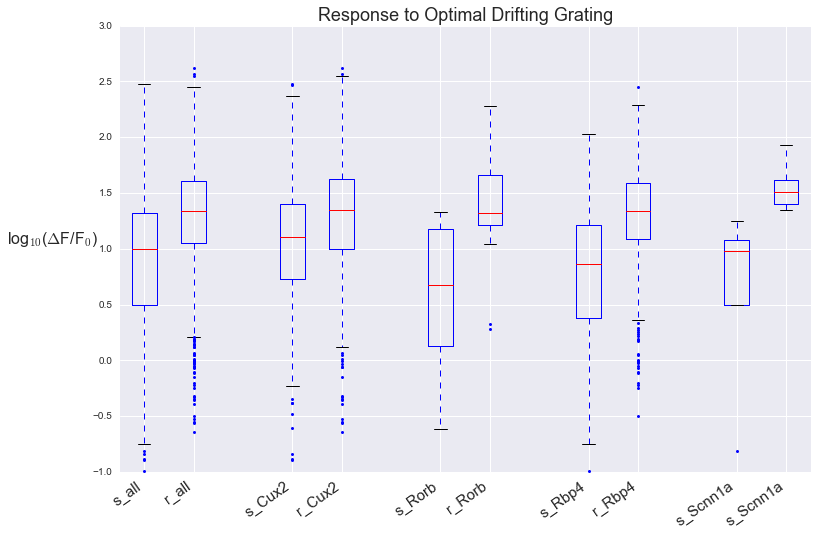

In [549]:
# fig, ax = plt.subplots(figsize=(12,8))
# ax.boxplot([walkRun_DG_DF.stat_all.trial_means,
#             walkRun_DG_DF.run_all.trial_means,
#             walkRun_DG_DF.stat_Cux2.trial_means,
#             walkRun_DG_DF.run_Cux2.trial_means,
#             walkRun_DG_DF.stat_Rorb.trial_means,
#             walkRun_DG_DF.run_Rorb.trial_means,
#             walkRun_DG_DF.stat_Rbp4.trial_means,
#             walkRun_DG_DF.run_Rbp4.trial_means,
#             walkRun_DG_DF.stat_Scnn1a.trial_means,
#             walkRun_DG_DF.run_Scnn1a.trial_means],
#        labels=['s_all','r_all','s_Cux2','r_Cux2','s_Rorb','r_Rorb','s_Rbp4','r_Rbp4','s_Scnn1a','s_Scnn1a'],
#           positions=[0,1,3,4,6,7,9,10,12,13])
# ax.set_ylim(-20,90)
# ax.set_ylabel('Response to Optimal Drifting Grating')

a = np.log10(walkRun_DG_DF.stat_all.trial_means)
b = np.log10(walkRun_DG_DF.run_all.trial_means)
c = np.log10(walkRun_DG_DF.stat_Cux2.trial_means)
d = np.log10(walkRun_DG_DF.run_Cux2.trial_means)
e = np.log10(walkRun_DG_DF.stat_Rorb.trial_means)
f = np.log10(walkRun_DG_DF.run_Rorb.trial_means)
g = np.log10(walkRun_DG_DF.stat_Rbp4.trial_means)
h = np.log10(walkRun_DG_DF.run_Rbp4.trial_means)
i = np.log10(walkRun_DG_DF.stat_Scnn1a.trial_means)
j = np.log10(walkRun_DG_DF.run_Scnn1a.trial_means)
tmp = [a,b,c,d,e,f,g,h,i,j]

fig,ax = plt.subplots(figsize=(12,8))
ax.boxplot([i[~np.isnan(i)] for i in tmp],positions=[0,1,3,4,6,7,9,10,12,13],sym='k.',widths=0.5);
ax.set_ylim(-1,3)
ax.set_xlim(-0.5,13.5)
ax.set_ylabel('log$_{10}$($\Delta$F/F$_0$)',fontsize=16, rotation=0)
ax.set_xticks([0,1,3,4,6,7,9,10,12,13])
ax.set_xticklabels(['s_all','r_all','s_Cux2','r_Cux2','s_Rorb','r_Rorb','s_Rbp4','r_Rbp4','s_Scnn1a','s_Scnn1a'], 
                   rotation=35, ha='right', fontsize = 15)
ax.yaxis.labelpad = 40
ax.set_title('Response to Optimal Drifting Grating', fontsize=18)
fig.subplots_adjust(left=0.15,right=0.95)
plt.savefig('/Users/bilalbari/Dropbox/SWDB_BLAZEN_NEURONZZ/finalPresentation/runModulation_DG_cre.png')

# Analyze all SG (three_session_B), subdivided by targeted_structure and cre_line

In [36]:
cells.columns

Index([u'area', u'cell_specimen_id', u'dsi_dg', u'experiment_container_id',
       u'imaging_depth', u'osi_dg', u'osi_sg', u'p_dg', u'p_ns', u'p_sg',
       u'pref_dir_dg', u'pref_image_ns', u'pref_ori_sg', u'pref_phase_sg',
       u'pref_sf_sg', u'pref_tf_dg', u'time_to_peak_ns', u'time_to_peak_sg',
       u'tld1_id', u'tld1_name', u'tld2_id', u'tld2_name', u'tlr1_id',
       u'tlr1_name'],
      dtype='object')

In [45]:
walkRun_SG_DF = pd.DataFrame(columns = ['stat_all','run_all','stat_VISp','run_VISp','stat_VISpm','run_VISpm',
                                     'stat_VISl','run_VISl','stat_VISal','run_VISal',
                                     'stat_Cux2','run_Cux2','stat_Rorb','run_Rorb','stat_Rbp4','run_Rbp4',
                                     'stat_Scnn1a','run_Scnn1a'],
                         index = ['trial_means'])

osi_sgMax = 1.5
osi_sgMin = 0
walkThresh = 1
runThresh = 5

for expType in range(9):
    walkMeans = []
    runMeans = []
    if expType == 0:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B')]
        print("three_session_B")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 1:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISp')]
        print("three_session_B and VISp")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 2:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISpm')]
        print("three_session_B and VISpm")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 3:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISl')]
        print("three_session_B and VISl")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 4:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISal')]
        print("three_session_B and VISal")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 5:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Cux2-CreERT2')]
        print("three_session_B and Cux2")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 6:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Rorb-IRES2-Cre')]
        print("three_session_B and Rorb")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 7:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Rbp4-Cre')]
        print("three_session_B and Rbp4")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 8:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Scnn1a-Tg3-Cre')]
        print("three_session_B and Scnn1a")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])

    for expInd in currSess_metaData.index:
        expContainerID = currSess_metaData.experiment_container_id[expInd]
        expID = currSess_metaData.id[expInd]
        exp = boc.get_ophys_experiment_data(ophys_experiment_id = expID)
        _, dF = exp.get_dff_traces()
        path = r'/Volumes/Brain2016/BrainObservatory/ophys_analysis/%d_%s_analysis.h5' % (expID, currSess_metaData.session_type[expInd])
        sResp = pd.read_hdf(path, 'analysis/sweep_response_sg')
        sResp_mean = pd.read_hdf(path, 'analysis/mean_sweep_response_sg')
        sTabl = pd.read_hdf(path, 'analysis/stim_table_sg')
        cellIDs = exp.get_cell_specimen_ids()

        relevCells = cells[cells.experiment_container_id == int(expContainerID)]
        relevCells = relevCells[~np.isnan(relevCells.osi_sg) & \
                                   np.less_equal(relevCells.osi_sg,osi_sgMax) & \
                                   np.greater_equal(relevCells.osi_sg,osi_sgMin)] # relevant cells are those with osi_sg and within bounds

        for currCell in relevCells.index:
            cellInd = np.where(relevCells.cell_specimen_id[currCell] == cellIDs)[0][0]
            prefOri = relevCells.pref_ori_sg[currCell]
            prefSF = relevCells.pref_sf_sg[currCell]
            prefPhase = relevCells.pref_phase_sg[currCell]
            
            

            allRun = []
            prefOri_mask = sTabl.orientation == prefOri
            prefSF_mask = sTabl.spatial_frequency == prefSF
            prefPhase_mask = sTabl.phase == prefPhase
            for currSweep in sTabl[prefOri_mask & prefSF_mask & prefPhase_mask].index:
                allRun.append(sResp_mean['dx'][currSweep])
            runMask = np.greater_equal(allRun,runThresh)
            stillMask = np.less(allRun,walkThresh)
            
            if (sum(runMask) >= 5) and (sum(stillMask) >= 5): # if <5 trials running or stationary
                walkVals = sResp_mean[str(cellInd)][prefOri_mask & prefSF_mask & prefPhase_mask][stillMask]
                runVals = sResp_mean[str(cellInd)][prefOri_mask & prefSF_mask & prefPhase_mask][runMask]
                
                meanFlag = False
                for tmp in walkVals:
                    if np.greater_equal(tmp,50):
                        meanFlag = True
                for tmp in runVals:
                    if np.greater_equal(tmp,50):
                        meanFlag = True

                if meanFlag == True:
                    walkMeans.append(walkVals.mean())
                    runMeans.append(runVals.mean())
    if expType == 0:
        walkRun_SG_DF.stat_all.trial_means = walkMeans
        walkRun_SG_DF.run_all.trial_means = runMeans
    elif expType == 1:
        walkRun_SG_DF.stat_VISp.trial_means = walkMeans
        walkRun_SG_DF.run_VISp.trial_means = runMeans
    elif expType == 2:
        walkRun_SG_DF.stat_VISpm.trial_means = walkMeans
        walkRun_SG_DF.run_VISpm.trial_means = runMeans
    elif expType == 3:
        walkRun_SG_DF.stat_VISl.trial_means = walkMeans
        walkRun_SG_DF.run_VISl.trial_means = runMeans
    elif expType == 4:
        walkRun_SG_DF.stat_VISal.trial_means = walkMeans
        walkRun_SG_DF.run_VISal.trial_means = runMeans
    elif expType == 5:
        walkRun_SG_DF.stat_Cux2.trial_means = walkMeans
        walkRun_SG_DF.run_Cux2.trial_means = runMeans
    elif expType == 6:
        walkRun_SG_DF.stat_Rorb.trial_means = walkMeans
        walkRun_SG_DF.run_Rorb.trial_means = runMeans
    elif expType == 7:
        walkRun_SG_DF.stat_Rbp4.trial_means = walkMeans
        walkRun_SG_DF.run_Rbp4.trial_means = runMeans
    elif expType == 8:
        walkRun_SG_DF.stat_Scnn1a.trial_means = walkMeans
        walkRun_SG_DF.run_Scnn1a.trial_means = runMeans
print("Done")

three_session_B
	79 sessions to sort through
three_session_B and VISp
	25 sessions to sort through
three_session_B and VISpm
	21 sessions to sort through
three_session_B and VISl
	16 sessions to sort through
three_session_B and VISal
	17 sessions to sort through
three_session_B and Cux2
	42 sessions to sort through
three_session_B and Rorb
	17 sessions to sort through
three_session_B and Rbp4
	16 sessions to sort through
three_session_B and Scnn1a
	4 sessions to sort through
Done


## Boxplot by Area

In [574]:
np.median((i[~np.isnan(i)]))

1.5064524966787827

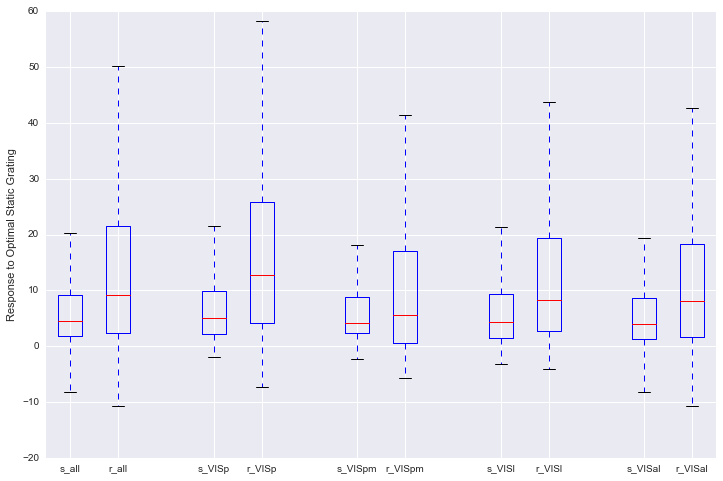

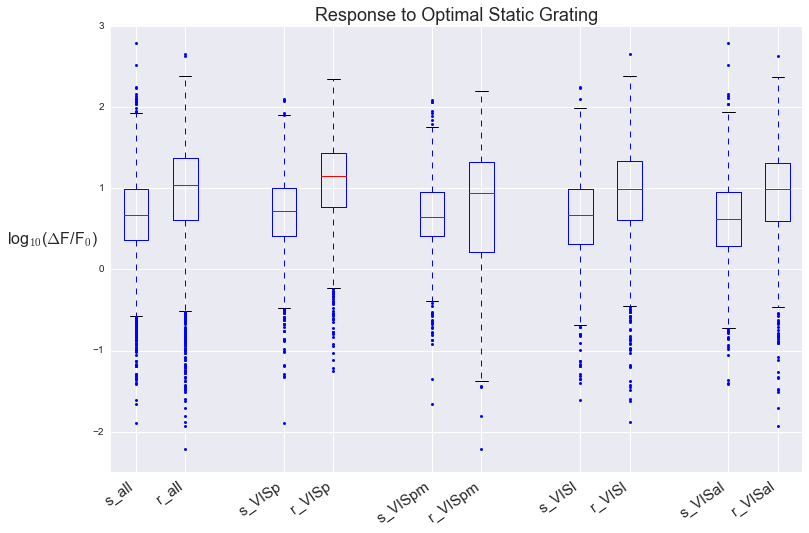

In [578]:
a = walkRun_SG_DF.stat_all.trial_means
b = walkRun_SG_DF.run_all.trial_means
c = walkRun_SG_DF.stat_VISp.trial_means
d = walkRun_SG_DF.run_VISp.trial_means
e = walkRun_SG_DF.stat_VISpm.trial_means
f = walkRun_SG_DF.run_VISpm.trial_means
g = walkRun_SG_DF.stat_VISl.trial_means
h = walkRun_SG_DF.run_VISl.trial_means
i = walkRun_SG_DF.stat_VISal.trial_means
j = walkRun_SG_DF.run_VISal.trial_means

fig, ax = plt.subplots(figsize=(12,8))
ax.boxplot([a,b,c,d,e,f,g,h,i,j],
       labels=['s_all','r_all','s_VISp','r_VISp','s_VISpm','r_VISpm','s_VISl','r_VISl','s_VISal','r_VISal'],
           positions=[0,1,3,4,6,7,9,10,12,13])
ax.set_ylim(-20,60)
ax.set_ylabel('Response to Optimal Static Grating')


a = np.log10(a)
b = np.log10(b)
c = np.log10(c)
d = np.log10(d)
e = np.log10(e)
f = np.log10(f)
g = np.log10(g)
h = np.log10(h)
i = np.log10(i)
j = np.log10(j)
tmp = [a,b,c,d,e,f,g,h,i,j]

fig,ax = plt.subplots(figsize=(12,8))
ax.boxplot([i[~np.isnan(i)] for i in tmp],positions=[0,1,3,4,6,7,9,10,12,13],sym='k.',widths=0.5);
# ax.set_ylim(-1,3)
ax.set_xlim(-0.5,13.5)
ax.set_ylim(-2.5,3)
ax.set_ylabel('log$_{10}$($\Delta$F/F$_0$)',fontsize=16, rotation=0)
ax.set_xticks([0,1,3,4,6,7,9,10,12,13])
ax.set_xticklabels(['s_all','r_all','s_VISp','r_VISp','s_VISpm','r_VISpm','s_VISl','r_VISl','s_VISal','r_VISal'], 
                   rotation=35, ha='right', fontsize = 15)
ax.yaxis.labelpad = 40
ax.set_title('Response to Optimal Static Grating', fontsize=18)
fig.subplots_adjust(left=0.15,right=0.95)
plt.savefig('/Users/bilalbari/Dropbox/SWDB_BLAZEN_NEURONZZ/finalPresentation/runModulation_SG_regions.png')

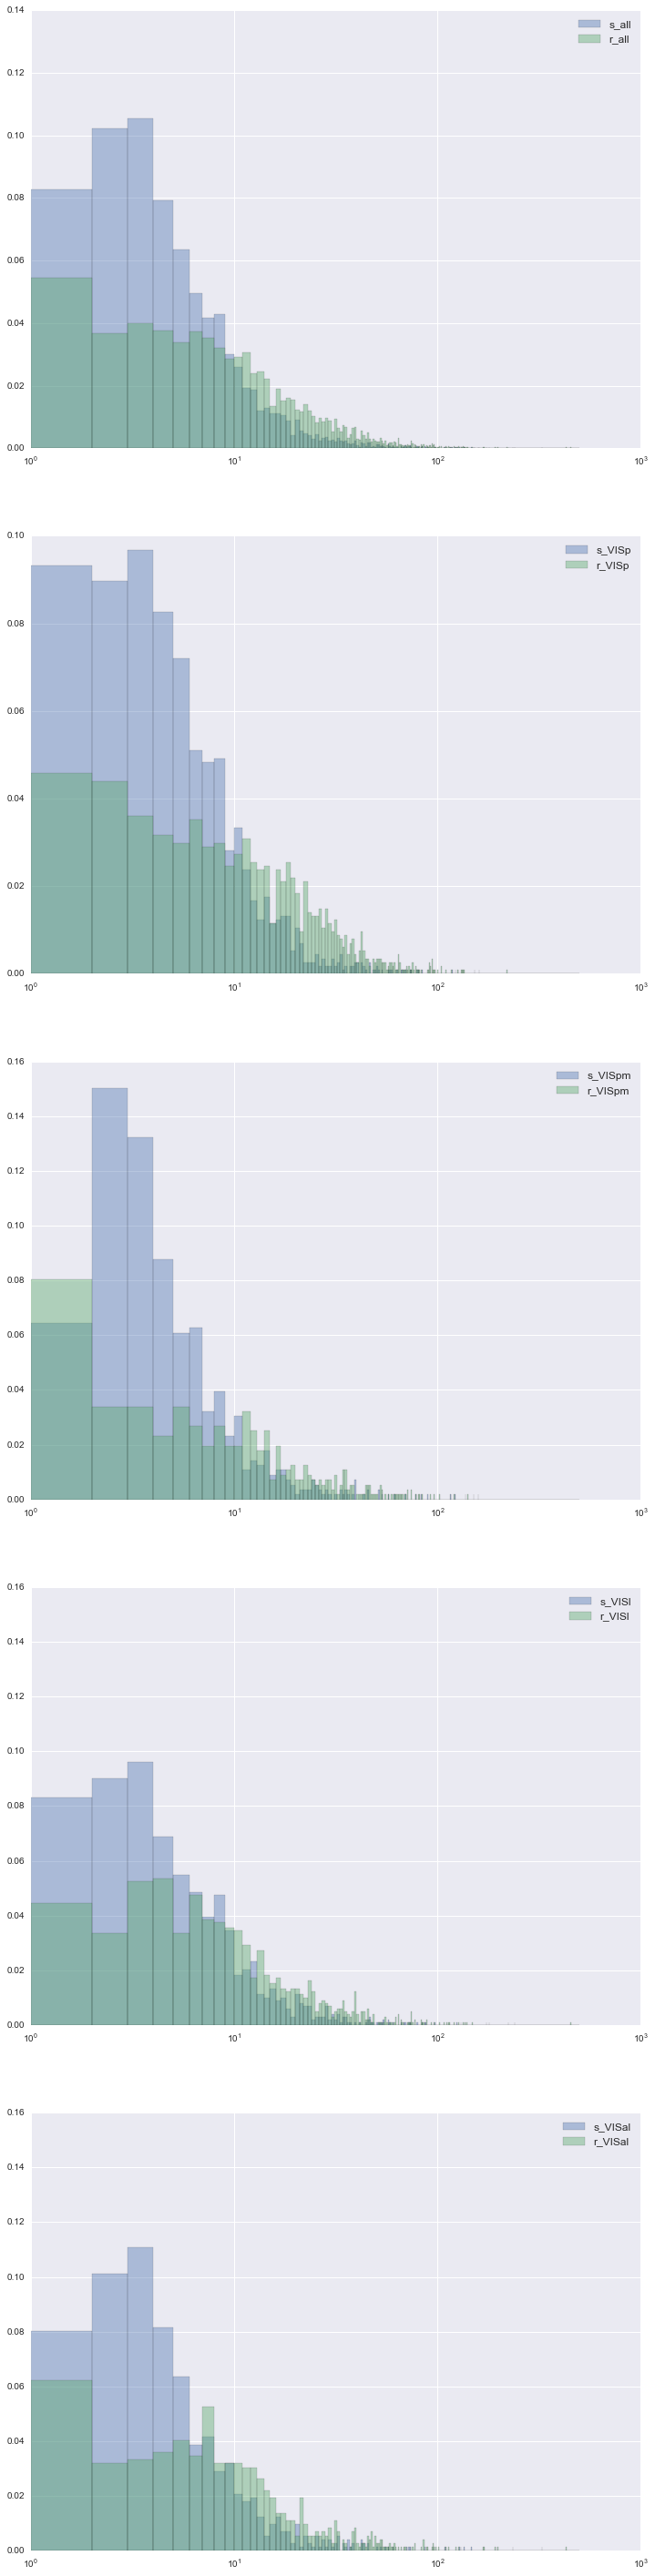

In [386]:
fig,ax = plt.subplots(nrows=5,figsize=(12,50))

a = walkRun_SG_DF.stat_all.trial_means
b = walkRun_SG_DF.run_all.trial_means
ax[0].hist(a,weights=np.zeros_like(a) + 1. / len(a),bins=np.arange(0,500,1),alpha=0.4,label='s_all');
ax[0].hist(b,weights=np.zeros_like(b) + 1. / len(b),bins=np.arange(0,500,1),alpha=0.4,label='r_all');
a = walkRun_SG_DF.stat_VISp.trial_means
b = walkRun_SG_DF.run_VISp.trial_means
ax[1].hist(a,weights=np.zeros_like(a) + 1. / len(a),bins=np.arange(0,500,1),alpha=0.4,label='s_VISp');
ax[1].hist(b,weights=np.zeros_like(b) + 1. / len(b),bins=np.arange(0,500,1),alpha=0.4,label='r_VISp');
a = walkRun_SG_DF.stat_VISpm.trial_means
b = walkRun_SG_DF.run_VISpm.trial_means
ax[2].hist(a,weights=np.zeros_like(a) + 1. / len(a),bins=np.arange(0,500,1),alpha=0.4,label='s_VISpm');
ax[2].hist(b,weights=np.zeros_like(b) + 1. / len(b),bins=np.arange(0,500,1),alpha=0.4,label='r_VISpm');
a = walkRun_SG_DF.stat_VISl.trial_means
b = walkRun_SG_DF.run_VISl.trial_means
ax[3].hist(a,weights=np.zeros_like(a) + 1. / len(a),bins=np.arange(0,500,1),alpha=0.4,label='s_VISl');
ax[3].hist(b,weights=np.zeros_like(b) + 1. / len(b),bins=np.arange(0,500,1),alpha=0.4,label='r_VISl');
a = walkRun_SG_DF.stat_VISal.trial_means
b = walkRun_SG_DF.run_VISal.trial_means
ax[4].hist(a,weights=np.zeros_like(a) + 1. / len(a),bins=np.arange(0,500,1),alpha=0.4,label='s_VISal');
ax[4].hist(b,weights=np.zeros_like(b) + 1. / len(b),bins=np.arange(0,500,1),alpha=0.4,label='r_VISal');
for currAx in ax:
#     currAx.set_xlim(0,40)
    currAx.legend(loc='upper right', fontsize=12)
    currAx.set_xscale('log')

## Boxplot by Cre Line

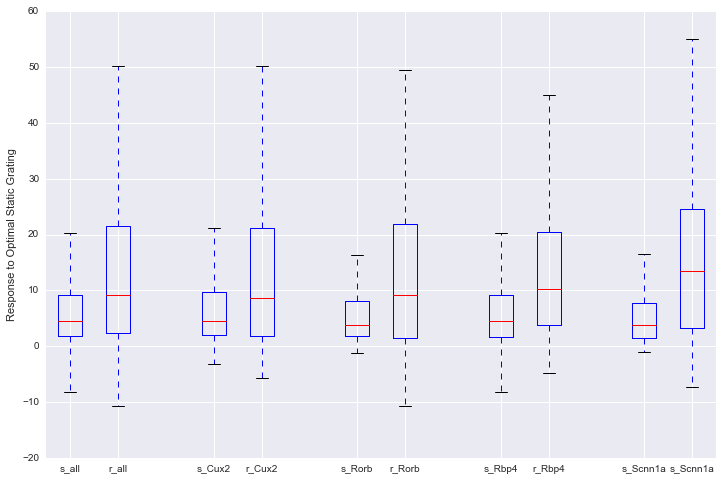

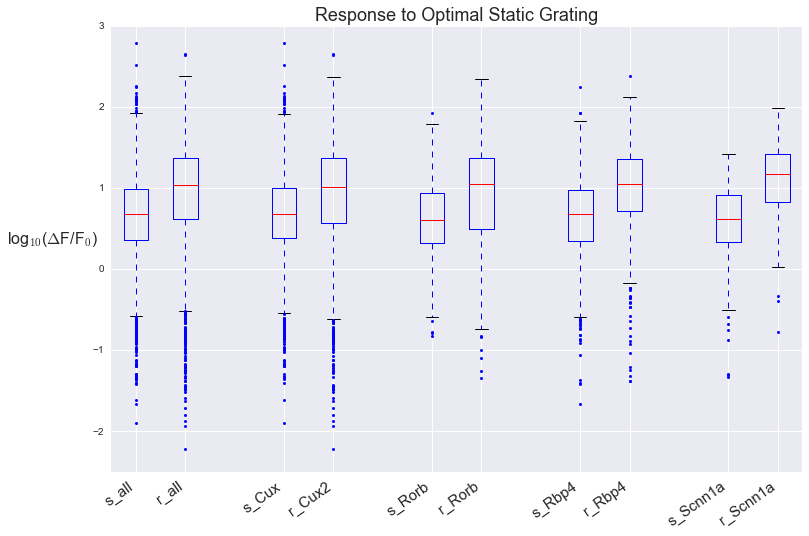

In [579]:
fig, ax = plt.subplots(figsize=(12,8))
ax.boxplot([walkRun_SG_DF.stat_all.trial_means,
            walkRun_SG_DF.run_all.trial_means,
            walkRun_SG_DF.stat_Cux2.trial_means,
            walkRun_SG_DF.run_Cux2.trial_means,
            walkRun_SG_DF.stat_Rorb.trial_means,
            walkRun_SG_DF.run_Rorb.trial_means,
            walkRun_SG_DF.stat_Rbp4.trial_means,
            walkRun_SG_DF.run_Rbp4.trial_means,
            walkRun_SG_DF.stat_Scnn1a.trial_means,
            walkRun_SG_DF.run_Scnn1a.trial_means],
       labels=['s_all','r_all','s_Cux2','r_Cux2','s_Rorb','r_Rorb','s_Rbp4','r_Rbp4','s_Scnn1a','s_Scnn1a'],
       positions=[0,1,3,4,6,7,9,10,12,13],
          whis = 1.5,showfliers=False, sym='k.')
ax.set_ylim(-20,60)
ax.set_ylabel('Response to Optimal Static Grating')


a = np.log10(walkRun_SG_DF.stat_all.trial_means)
b = np.log10(walkRun_SG_DF.run_all.trial_means)
c = np.log10(walkRun_SG_DF.stat_Cux2.trial_means)
d = np.log10(walkRun_SG_DF.run_Cux2.trial_means)
e = np.log10(walkRun_SG_DF.stat_Rorb.trial_means)
f = np.log10(walkRun_SG_DF.run_Rorb.trial_means)
g = np.log10(walkRun_SG_DF.stat_Rbp4.trial_means)
h = np.log10(walkRun_SG_DF.run_Rbp4.trial_means)
i = np.log10(walkRun_SG_DF.stat_Scnn1a.trial_means)
j = np.log10(walkRun_SG_DF.run_Scnn1a.trial_means)

tmp = [a,b,c,d,e,f,g,h,i,j]

fig,ax = plt.subplots(figsize=(12,8))
ax.boxplot([i[~np.isnan(i)] for i in tmp],positions=[0,1,3,4,6,7,9,10,12,13],n='k.',widths=0.5);
ax.set_ylim(-2.5,3)
ax.set_xlim(-0.5,13.5)
ax.set_ylabel('log$_{10}$($\Delta$F/F$_0$)',fontsize=16, rotation=0)
ax.set_xticks([0,1,3,4,6,7,9,10,12,13])
ax.set_xticklabels(['s_all','r_all','s_Cux','r_Cux2','s_Rorb','r_Rorb','s_Rbp4','r_Rbp4','s_Scnn1a','r_Scnn1a'], 
                   rotation=35, ha='right', fontsize = 15)
ax.yaxis.labelpad = 40
ax.set_title('Response to Optimal Static Grating', fontsize=18)
fig.subplots_adjust(left=0.15,right=0.95)
plt.savefig('/Users/bilalbari/Dropbox/SWDB_BLAZEN_NEURONZZ/finalPresentation/runModulation_SG_cre.png')

## Variability (Annie)

In [94]:
variability_DG_DF = pd.DataFrame(columns = ['std_all','std_VISp','std_VISpm','std_VISl','std_VISal','std_Cux2',
                                            'std_Rorb','std_Rbp4','std_Scnn1a'],
                         index = ['std'])

osi_dgMax = 1.5
osi_dgMin = 0
walkThresh = 1
runThresh = 5

for expType in range(9):
    stim_STDs = []
    if expType == 0:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A')]
        print("three_session_A")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 1:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.targeted_structure == 'VISp')]
        print("three_session_A and VISp")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 2:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.targeted_structure == 'VISpm')]
        print("three_session_A and VISpm")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 3:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.targeted_structure == 'VISl')]
        print("three_session_A and VISl")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 4:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.targeted_structure == 'VISal')]
        print("three_session_A and VISal")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 5:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.cre_line == 'Cux2-CreERT2')]
        print("three_session_A and Cux2")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 6:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.cre_line == 'Rorb-IRES2-Cre')]
        print("three_session_A and Rorb")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 7:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.cre_line == 'Rbp4-Cre')]
        print("three_session_A and Rbp4")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 8:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_A') & (expMetaData.cre_line == 'Scnn1a-Tg3-Cre')]
        print("three_session_A and Scnn1a")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])

    for expInd in currSess_metaData.index:
        expContainerID = currSess_metaData.experiment_container_id[expInd]
        expID = currSess_metaData.id[expInd]
        exp = boc.get_ophys_experiment_data(ophys_experiment_id = expID)
        _, dF = exp.get_dff_traces()
        path = r'/Volumes/Brain2016/BrainObservatory/ophys_analysis/%d_%s_analysis.h5' % (expID, currSess_metaData.session_type[expInd])
        sResp = pd.read_hdf(path, 'analysis/sweep_response_dg')
        sResp_mean = pd.read_hdf(path, 'analysis/mean_sweep_response_dg')
        sTabl = pd.read_hdf(path, 'analysis/stim_table_dg')
        cellIDs = exp.get_cell_specimen_ids()

        relevCells = cells[cells.experiment_container_id == int(expContainerID)]
        relevCells = relevCells[~np.isnan(relevCells.osi_dg) & \
                                   np.less_equal(relevCells.osi_dg,osi_dgMax) & \
                                   np.greater_equal(relevCells.osi_dg,osi_dgMin)] # relevant cells are those with osi_dg and within bounds

        for currCell in relevCells.index:
            cellInd = np.where(relevCells.cell_specimen_id[currCell] == cellIDs)[0][0]
            prefDir = relevCells.pref_dir_dg[currCell]
            prefTF = relevCells.pref_tf_dg[currCell]

            prefTF_mask = sTabl.temporal_frequency == prefTF
            prefDir_mask = sTabl.orientation == prefDir

            cellResponses = sResp_mean[str(cellInd)][prefTF_mask & prefDir_mask]
            stim_STDs.append(np.std(cellResponses))

    if expType == 0:
        variability_DG_DF.std_all.std = stim_STDs
    elif expType == 1:
        variability_DG_DF.std_VISp.std = stim_STDs
    elif expType == 2:
        variability_DG_DF.std_VISpm.std = stim_STDs
    elif expType == 3:
        variability_DG_DF.std_VISl.std = stim_STDs
    elif expType == 4:
        variability_DG_DF.std_VISal.std = stim_STDs
    elif expType == 5:
        variability_DG_DF.std_Cux2.std = stim_STDs
    elif expType == 6:
        variability_DG_DF.std_Rorb.std = stim_STDs
    elif expType == 7:
        variability_DG_DF.std_Rbp4.std = stim_STDs
    elif expType == 8:
        variability_DG_DF.std_Scnn1a.std = stim_STDs
print("Done")

three_session_A
	79 sessions to sort through
three_session_A and VISp
	25 sessions to sort through
three_session_A and VISpm
	21 sessions to sort through
three_session_A and VISl
	16 sessions to sort through
three_session_A and VISal
	17 sessions to sort through
three_session_A and Cux2
	42 sessions to sort through
three_session_A and Rorb
	17 sessions to sort through
three_session_A and Rbp4
	16 sessions to sort through
three_session_A and Scnn1a
	4 sessions to sort through
Done


In [99]:
variability_DG_DF.std_VISpm.std

[42.267784957331116,
 28.304638703600915,
 50.48909435376837,
 12.35065214903714,
 23.4439029180211,
 5.449254058135222,
 9.41301747224662,
 5.359058265203595,
 24.462872648303332,
 6.189092883115978,
 20.691819719206137,
 12.625477544330089,
 12.828277048553536,
 13.281292486233268,
 25.545414485122873,
 34.63737146762229,
 13.287925193653365,
 41.860796055822604,
 8.22196646035689,
 27.864783913601336,
 35.878191362533656,
 58.85360484283959,
 8.297377416046508,
 5.805088734961455,
 24.897923780224954,
 53.4828554358673,
 3.311260939900561,
 52.300576142196554,
 100.67307703656869,
 55.47104220176464,
 8.202021394207128,
 71.03914923623799,
 95.20949403429537,
 71.26675173021637,
 20.668481413321903,
 13.143486550054867,
 24.317569007496836,
 19.993791529561793,
 10.046068132925285,
 4.114233526781384,
 20.63171399424169,
 8.482766205134153,
 36.024675064833474,
 4.5535403657394795,
 10.797639907510797,
 3.659203438522975,
 20.267601812180242,
 39.05754175640892,
 18.871730843924343,

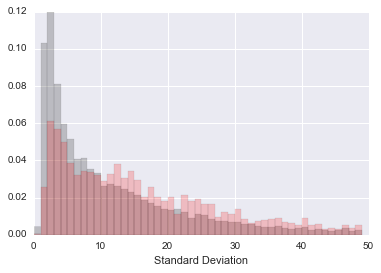

In [391]:
fig,ax = plt.subplots()
arr1 = variability_DG_DF.std_all.std
arr2 = variability_DG_DF.std_Rbp4.std
# arr3 = variability_DG_DF.std_Scnn1a.std
ax.hist(arr1,bins=np.arange(0,50),alpha=0.2,color='black',weights=np.zeros_like(arr1) + 1. / len(arr1));
ax.hist(arr2,bins=np.arange(0,50),alpha=0.2,color='red',weights=np.zeros_like(arr2) + 1. / len(arr2));
# ax.hist(arr3,bins=np.arange(0,50),alpha=0.2,color='green',weights=np.zeros_like(arr3) + 1. / len(arr3))
ax.set_xlabel('Standard Deviation')
# ax.set_xscale('log')

In [135]:
print len(walkRun_DG_DF.stat_all.trial_means)
print len(walkRun_DG_DF.stat_VISp.trial_means)
print len(walkRun_DG_DF.stat_VISpm.trial_means)
print len(walkRun_DG_DF.stat_VISl.trial_means)
print len(walkRun_DG_DF.stat_VISal.trial_means)
print len(walkRun_DG_DF.stat_Cux2.trial_means)
print len(walkRun_DG_DF.stat_Rorb.trial_means)
print len(walkRun_DG_DF.stat_Rbp4.trial_means)
print len(walkRun_DG_DF.stat_Scnn1a.trial_means)
walkRun_DG_DF.head()

734
189
152
271
122
395
25
309
5


,stat_all,run_all,stat_VISp,run_VISp,stat_VISpm,run_VISpm,stat_VISl,run_VISl,stat_VISal,run_VISal,stat_Cux2,run_Cux2,stat_Rorb,run_Rorb,stat_Rbp4,run_Rbp4,stat_Scnn1a,run_Scnn1a
trial_means,"[15.6986445636, 0.541182316095, 2.304666996, 0...","[2.13974773884, 16.966840148, 19.1783124924, 1...","[15.6986445636, 0.541182316095, 2.304666996, 0...","[2.13974773884, 16.966840148, 19.1783124924, 1...","[22.7771039903, 25.8687523305, 52.0697451168, ...","[0.277761723314, 26.876226902, 4.34744631251, ...","[1.37016425328, 2.36911569701, 121.202106357, ...","[17.3857116699, 24.8697773616, 87.8350028992, ...","[0.00188424997032, 7.19560775492, -1.836883474...","[47.3026708762, 0.469205249101, 15.3048122397,...","[1.37016425328, 2.36911569701, 121.202106357, ...","[17.3857116699, 24.8697773616, 87.8350028992, ...","[15.6986445636, 0.541182316095, 2.304666996, 0...","[2.13974773884, 16.966840148, 19.1783124924, 1...","[14.8179041545, 2.08200335503, 10.9565176964, ...","[78.2076708476, 124.614014217, 1.88536442071, ...","[8.54624689288, 10.5370936493, -0.569350338644...","[25.0860919952, 84.912443161, 32.0961171627, 4..."


In [397]:
walkRun_DG_DF.to_csv('walkRun_DG_DF.csv','\t')

In [459]:
variability_DG_DF_2 = pd.DataFrame(columns = ['std_all','std_VISp','std_VISpm','std_VISl','std_VISal','std_Cux2',
                                            'std_Rorb','std_Rbp4','std_Scnn1a'],index= [0])
variability_DG_DF_2.head()
variability_DG_DF_2.std_all[0] = np.asarray(variability_DG_DF.std_all.std)
variability_DG_DF_2.std_VISp[0] = np.asarray(variability_DG_DF.std_VISp.std)
variability_DG_DF_2.std_VISpm[0] = np.asarray(variability_DG_DF.std_VISpm.std)
variability_DG_DF_2.std_VISl[0] = np.asarray(variability_DG_DF.std_VISl.std)
variability_DG_DF_2.std_VISal[0] = np.asarray(variability_DG_DF.std_VISal.std)
variability_DG_DF_2.std_Cux2[0] = np.asarray(variability_DG_DF.std_Cux2.std)
variability_DG_DF_2.std_Rorb[0] = np.asarray(variability_DG_DF.std_Rorb.std)
variability_DG_DF_2.std_Rbp4[0] = np.asarray(variability_DG_DF.std_Rbp4.std)
variability_DG_DF_2.std_Scnn1a[0] = np.asarray(variability_DG_DF.std_Scnn1a.std)

In [470]:
variability_DG_DF_2.to_json('variability_DG_DF_2.json')
walkRun_DG_DF.to_json('walkRun_DG_DF.json')
walkRun_SG_DF.to_json('walkRun_SG_DF.json')

,std_Cux2,std_Rbp4,std_Rorb,std_Scnn1a,std_VISal,std_VISl,std_VISp,std_VISpm,std_all
0,"[19.9297035389, 18.425345597, 7.9903801611, 12...","[42.2677849573, 28.3046387036, 50.4890943538, ...","[3.2004315233, 13.8058537131, 4.114558734, 5.1...","[22.8859418584, 26.7272628015, 4.3293330215, 3...","[5.0551094802, 11.029974516, 53.4724193625, 7....","[15.8763620492, 2.6125439799, 6.3677268874, 11...","[3.2004315233, 13.8058537131, 4.114558734, 5.1...","[42.2677849573, 28.3046387036, 50.4890943538, ...","[42.2677849573, 28.3046387036, 50.4890943538, ..."
